In [1]:
# dev 20250214
!git clone https://github.com/ipmu-lab/sciencecamp2025.git
%cd ./sciencecamp2025/

Cloning into 'sciencecamp2025'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 50 (delta 9), reused 41 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 848.95 KiB | 9.65 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/sciencecamp2025


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./src/graph_preset.mplstyle')
from scipy.constants import * # https://docs.scipy.org/doc/scipy/reference/constants.html

'''
 * Author: Ryosuke AKIZAWA (ryosuke.akizawa@ipmu.jp)
 * Original Author: Takumi IZAWA (takumi.izawa@ipmu.jp)
 * Date: 2025-02-07
 * Version: 1.0
 * Description: for Kashiwa-Science-Camp
 * Internal Use Only
'''

'\n * Author: Ryosuke AKIZAWA (ryosuke.akizawa@ipmu.jp)\n * Original Author: Takumi IZAWA (takumi.izawa@ipmu.jp)\n * Date: 2025-02-07\n * Version: 1.0\n * Description: for Kashiwa-Science-Camp\n * Internal Use Only\n'

In [3]:
def tra_model(n0,ns,n1,d,freq):
    x = 2*np.pi*freq*n1*d/c*10**9
    return 4*n0*ns*n1**2/(n1**2*(n0+ns)**2*np.cos(x)**2+(n0*ns+n1**2)**2*np.sin(x)**2) # Eq. (7.30)

def tra_chi2(tra_data, sigma_weight, freq, n0, ns, n1, d, num_of_param=1):
    """
    Calculate the reduced chi-squared for the transmission model.

    Parameters:
        tra_data (numpy.ndarray): Measured transmission data.
        sigma_weight (numpy.ndarray): Uncertainty (weights) of the measured data.
        freq (numpy.ndarray): Frequency data corresponding to the measurements.
        n0, ns, n1, d (float): Parameters for the transmission model.
        num_of_param (int): Number of free parameters in the fit. Default is 1.

    Returns:
        float: The reduced chi-squared value.
    """
    # Degrees of freedom (number of data points minus number of free parameters)
    dof = len(tra_data) - num_of_param

    # Calculate the model predictions using the transmission model
    model_values = tra_model(n0, ns, n1, d, freq)

    # Calculate the residuals (difference between measured data and model predictions)
    residual = tra_data - model_values

    # Calculate the chi-squared value
    chi2 = np.sum((residual / sigma_weight) ** 2)

    # Return the reduced chi-squared (chi² divided by degrees of freedom)
    return chi2 / dof

In [4]:
# Load the data
data_sample =  dict(np.load('./data/sampledata/mockdata_sample_p.npz'))

# check the data format
for key in data_sample.keys():
    print(f"  {key:<8}: (rows, columns) = {data_sample[key].shape}")

  freq    : (rows, columns) = (1000,)
  data    : (rows, columns) = (1000,)
  trans   : (rows, columns) = (1000,)
  phase   : (rows, columns) = (1000,)
  real    : (rows, columns) = (1000,)
  imag    : (rows, columns) = (1000,)


In [5]:
# Example model parameters
n0 = 1
ns = 1
d = 2.1e-3 # [m]

# Example of sigma_weight
sigma_weight = np.full(len(data_sample['freq']), 0.00984636)

# Search for the best n1 value
n1 = np.linspace(3.03, 3.05, 10000)

chi2_arr = np.zeros(len(n1))

for i in range(len(n1)):
    chi2_arr[i] = tra_chi2(data_sample['trans'], sigma_weight, data_sample['freq'], n0, ns, n1[i], d, num_of_param=1)

# Find the best n1 value
best_n1 = n1[np.argmin(chi2_arr)]

# Find the error of n1
n1_err_ind = np.where(chi2_arr <= np.min(chi2_arr) + 1)[0]
n1_low = n1[n1_err_ind[0]]
n1_high = n1[n1_err_ind[-1]]
n1_err = n1_high - n1_low # 1 sigma error
half_err = n1_err / 2

print(f"Best n1: {best_n1:.3f} ± {n1_err:.3f}")

Best n1: 3.041 ± 0.009


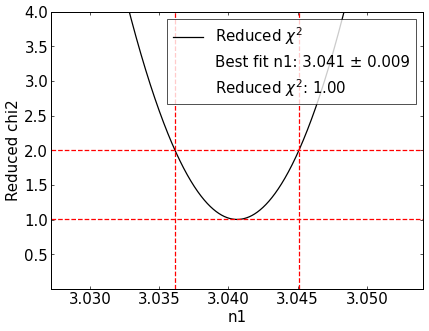

In [6]:
# Plot the reduced chi-squared value as a function of n1
fig,ax = plt.subplots(figsize=(8, 6), dpi=60)
ax.plot(n1, chi2_arr, label= r'Reduced $\chi^2$', color='black')
ax.set_xlabel('n1')
ax.set_ylabel('Reduced chi2')
ax.set_ylim(np.min(chi2_arr)-1, np.min(chi2_arr)+3)
ax.set_xlim(best_n1 - 3*half_err, best_n1 + 3*half_err)

# Plot the best n1 value and the error range
ax.axvline(n1_low, color='r', ls= '--')
ax.axvline(n1_high, color='r', ls= '--')

ax.axhline(np.min(chi2_arr), color='r', ls= '--')
ax.axhline(np.min(chi2_arr)+1, color='r', ls= '--')

ax.plot([],[],color='none',label=f"Best fit n1: {best_n1:.3f} ± {n1_err:.3f}")
ax.plot([],[],color='none',label=r"Reduced $\chi^2$: {:.2f}".format(np.min(chi2_arr)))

ax.legend(loc='upper right')